In [1]:
#Importaciones 

import pandas as pd
import numpy as np
from matplotlib import cm

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import mixture
from collections import Counter

# #Config 
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#Carga del Dataset

df = pd.read_csv('retail.csv')
print(df.info())
print(df.columns)

log_data = np.log(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None
Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')


In [3]:
#PCA
selected_features=[]
cntftr=0

for feature in df.columns.values:
    X = df.drop([feature],axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, df[feature], test_size=0.25, random_state=45)
    regressor = DecisionTreeRegressor(random_state=45).fit(X_train, y_train)
    score = regressor.score(X_test, y_test)
    if score <= 0:
        cntftr=cntftr+1
        selected_features.insert(cntftr,feature)

print(selected_features)

['Region', 'Fresh', 'Frozen', 'Delicassen']


In [4]:
#Data Clean 

possibles_cluster = list(range(2, 11))

outliers_counter = Counter()
outliers_scores = None 

for feature in log_data.keys():
    Q1 = np.percentile(log_data[feature], 25)
    Q3 = np.percentile(log_data[feature], 75)
    step = 1.5 * (Q3 - Q1)
    empty = np.zeros(len(log_data[feature]))
    aboveQ3 = log_data[feature].values - Q3 - step
    belowQ3 = log_data[feature].values - Q1 + step
    current_outliers_scores = np.array(np.maximum(empty, aboveQ3) - np.minimum(empty, belowQ3)).reshape([-1,1])
    outliers_scores = current_outliers_scores if outliers_scores is None else np.hstack([outliers_scores, current_outliers_scores])
    outliers_counter.update(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))].index.values)

min_outliers_count = 2
outliers = [x[0] for x in outliers_counter.items() if x[1] >= min_outliers_count]
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)
pca = PCA(n_components=2).fit(good_data)
reduced_data = pca.transform(good_data)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [5]:
#Config of Knn

kmeans_kwargs = {"init": "random","n_init": 10,"random_state": 10,"max_iter":1000}

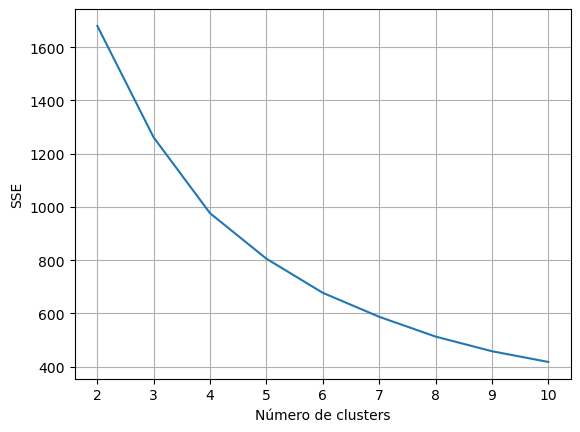

In [6]:
#Tecnica del Codo 

fig, axes = plt.subplots()

sse_knn = []
sse_gmm = []
for n_clusters in possibles_cluster:
    kmeans = KMeans(n_clusters=n_clusters, **kmeans_kwargs).fit(reduced_data)
    sse_knn.append(kmeans.inertia_)


_= axes.plot(possibles_cluster, sse_knn)
_= axes.grid(True)
_ = axes.set_xlabel("Número de clusters")
_ = axes.set_ylabel("SSE")

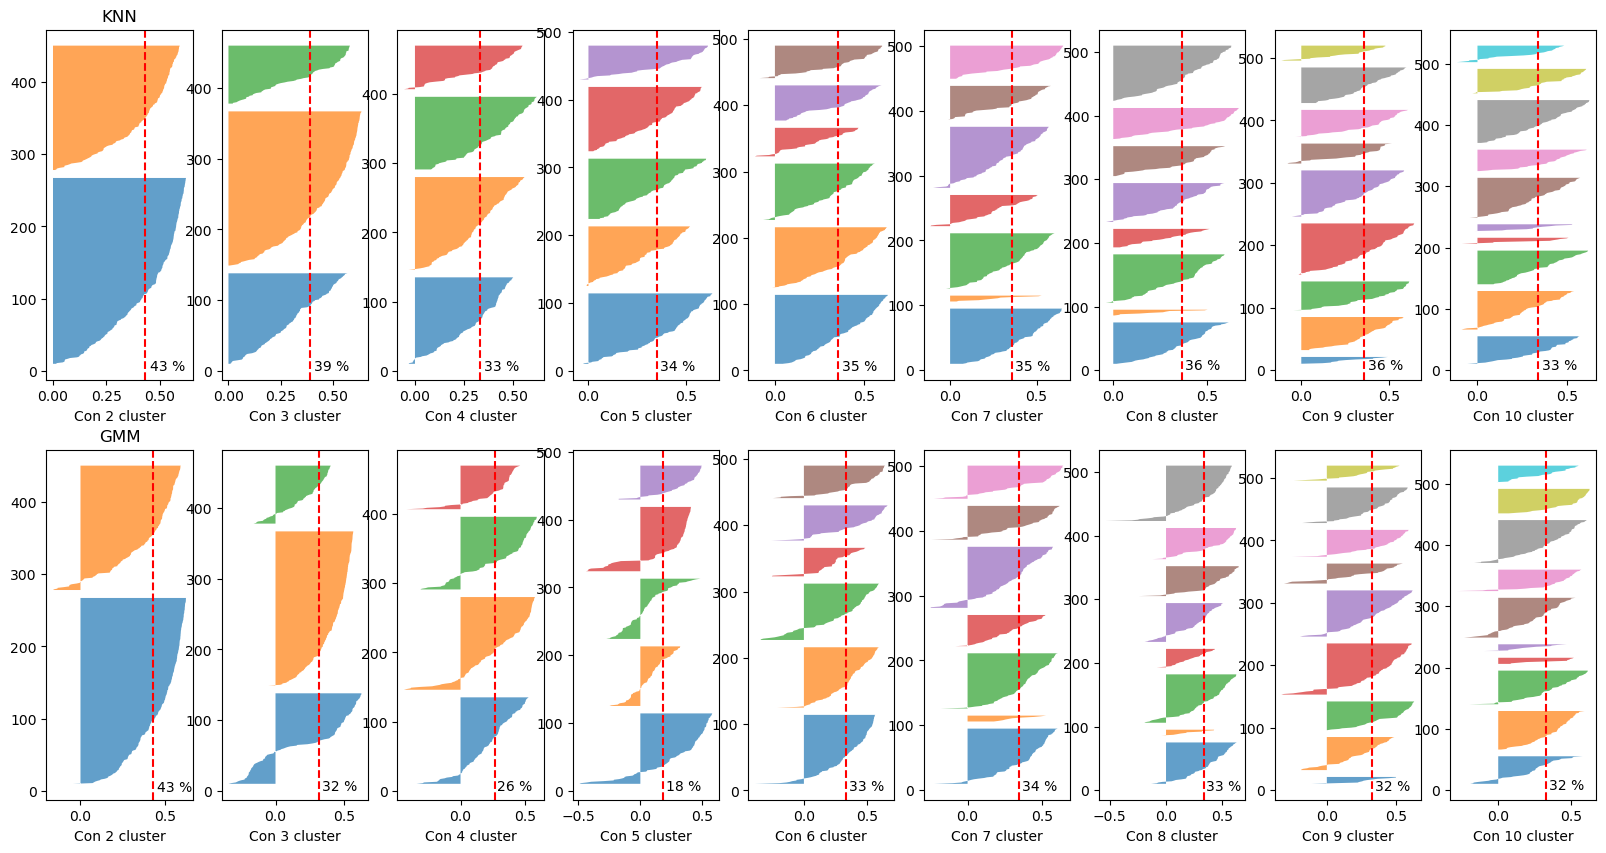

In [7]:
#Coeficiente de silhouette

fig, axes = plt.subplots(2, len(possibles_cluster),figsize=(20,10))

for index,n_clusters in enumerate(possibles_cluster):
        # KNN
        kmeans = KMeans(n_clusters=n_clusters,**kmeans_kwargs)
        y_kmeans = kmeans.fit_predict(reduced_data)
        sample_silhouette_values = silhouette_samples(reduced_data, y_kmeans)
        silhouette_avg = silhouette_score(reduced_data, y_kmeans)
        y_lower = 10
        _= axes[0,index].set_xlabel("Con " + str(n_clusters) + " cluster")
        _=axes[0,index].axvline(x=silhouette_avg, color="red", linestyle="--")
        _=axes[0,index].text(silhouette_avg+0.02, 0.5, str(int(silhouette_avg*100)) + " % ")
        _=axes[0,0].set_title("KNN")

        for i in range(n_clusters):
            ith_cluster_silhouette_values =sample_silhouette_values[y_kmeans == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            _=axes[0,index].fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,alpha=0.7)
            y_lower = y_upper + 10


        # GMM
        clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=45).fit(reduced_data)
        preds = clusterer.predict(reduced_data)
        sample_silhouette_values = silhouette_samples(reduced_data, preds)
        score = silhouette_score(reduced_data, preds)
        y_lower = 10
        _= axes[1,index].set_xlabel("Con " + str(n_clusters) + " cluster")
        _=axes[1,index].axvline(x=score, color="red", linestyle="--")
        _=axes[1,index].text(score+0.02, 0.1, str(int(score*100)) + " % ")
        _=axes[1,0].set_title("GMM")

        for i in range(n_clusters):
            ith_cluster_silhouette_values =sample_silhouette_values[y_kmeans == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            _=axes[1,index].fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,alpha=0.7)
            y_lower = y_upper + 10



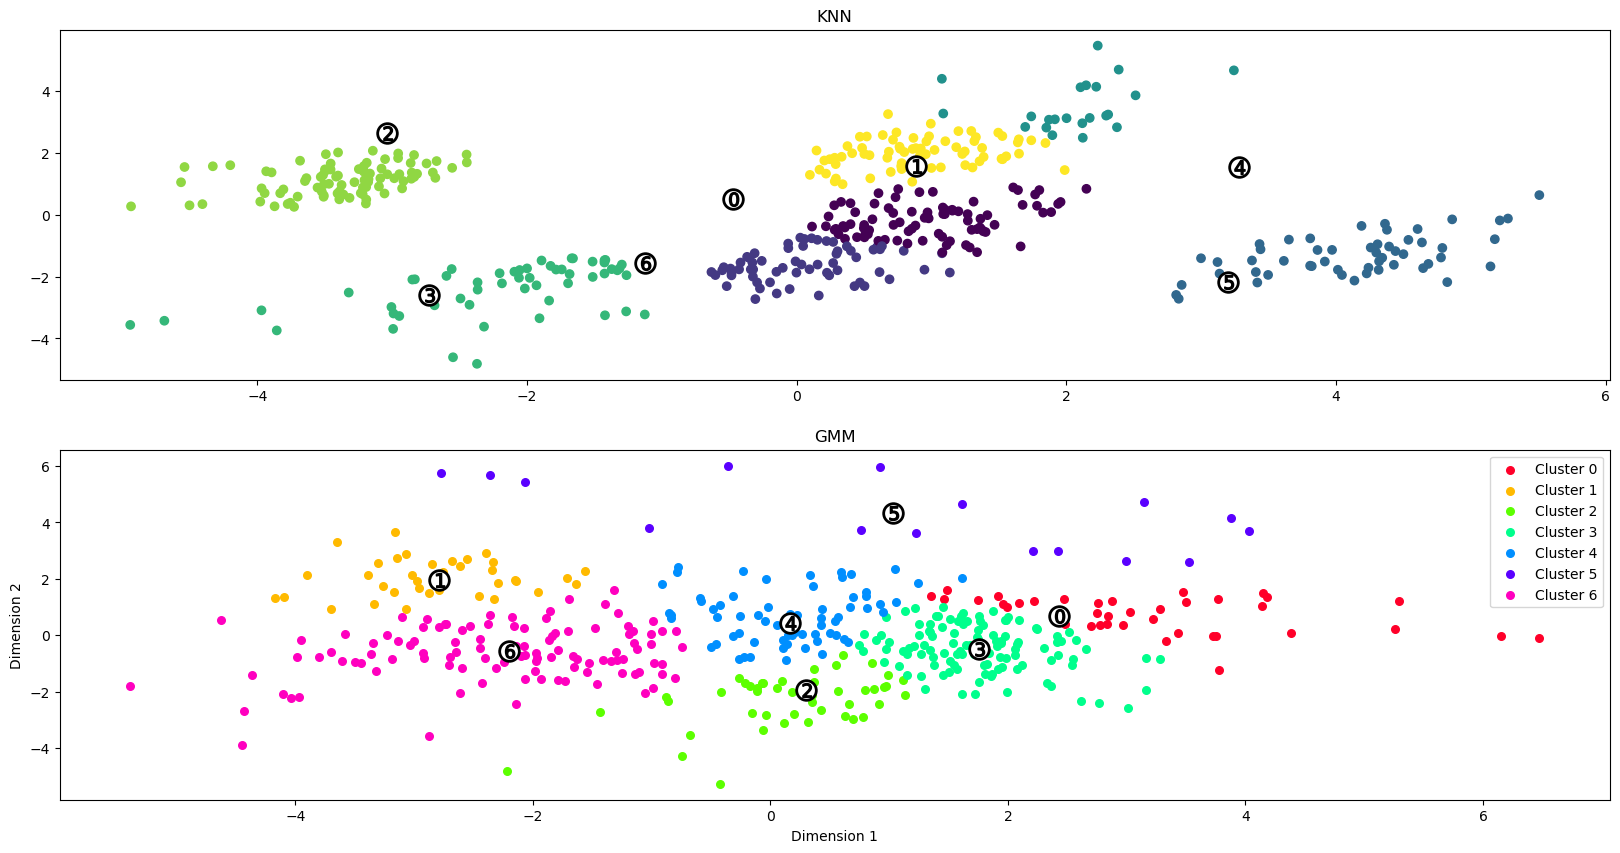

In [11]:
fig, ax = plt.subplots(2, 1,figsize=(20,10))
cmap = cm.get_cmap('gist_rainbow')
n_clusters = 7

df_knn= reduced_data.copy(deep=True)


# KMM
kmeans = KMeans(n_clusters=n_clusters, **kmeans_kwargs).fit(df_knn)
Etiquetas = kmeans.labels_
df_knn["cluster"] = Etiquetas
df_knn["cluster"] = df_knn["cluster"] + 1

pca = PCA(n_components=2)
scores_pca = pca.fit_transform(df_knn)
df_transform = pd.DataFrame(scores_pca)
EtiquetasScaladas = kmeans.fit_predict(scores_pca)

_= ax[0].scatter(df_transform.iloc[:, 0],df_transform.iloc[:, 1],c=EtiquetasScaladas)

CentrosScaladas = kmeans.cluster_centers_
Centros_pca = pca.fit_transform(CentrosScaladas)
_=ax[0].set_title("KNN")


for i, c in enumerate(Centros_pca):
    _=ax[0].scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', alpha = 1, linewidth = 2, marker = 'o', s=200)
    _=ax[0].scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100, color='black')


# GMM
clusterer = mixture.GaussianMixture(n_components=n_clusters).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_
preds = pd.DataFrame(preds, columns = ['Cluster'])
plot_data = pd.concat([preds, reduced_data], axis = 1)

for i, cluster in plot_data.groupby('Cluster'):   
    _= cluster.plot(ax = ax[1], kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30)

for i, c in enumerate(centers):
    _=ax[1].scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', alpha = 1, linewidth = 2, marker = 'o', s=200)
    _=ax[1].scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100, color='black')


_=ax[1].set_title("GMM")
